<a href="https://colab.research.google.com/github/rmorlowski/Regression-Analysis-and-Multivariate-Methods/blob/master/More_Ames_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  More Ames Housing Data

The deliverable is to analyze housing data from the Ames train dataset to predict the sale price (in dollars) of the Ames test dataset. This will be accomplished by generating multiple regression models using different variable selection techniques including, but not limited to, Forward, Stepwise and chi-square feature selection. From these techniques, the best model will be selected. The best model will then be further analyzed to determine if it is an adequate model to predict or if further analysis or data transformation is necessary.

See link to kaggle competition:
[Kaggle Competition](https://www.kaggle.com/c/ames-housing-data-summer-2018)

**Note: ** Winning model for the class #1 on leaderboard

In [1]:
#import some packages you will be using
import pandas as pd
import pandas_profiling
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt 
import scipy as scipy
from scipy import stats
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV
 
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
#set some options for the output
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 120)

In [3]:
# Import file to google colaboratory
from google.colab import files
# upload the train dataset
uploaded = files.upload()

Saving AMES_TRAIN.csv to AMES_TRAIN (1).csv


In [0]:
import io
#read in the datasets
train = pd.read_csv('AMES_TRAIN.csv')

In [5]:
# Import file to google colaboratory
# upload the test dataset
uploaded = files.upload()

Saving AMES_TEST_SFAM.csv to AMES_TEST_SFAM (1).csv


In [0]:
#read in the datasets
test = pd.read_csv('AMES_TEST_SFAM.csv')


In [0]:
#A good step to take is to convert all variable names to lower case
train.columns = [s.lower() for s in train.columns]
test.columns = [s.lower() for s in test.columns]

In [10]:
print('')
print('----- Data Preprocessing -----')
print('')


----- Data Preprocessing -----



In [11]:
#Do we have missing values? 
datasetHasNan = False
if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] :
    print('We do not need to worry about missing values.') 
else:
    datasetHasNan = True
    print('oops we have nan')

oops we have nan


In [12]:
print('----train dataset column types information-------')
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

----train dataset column types information-------


  Column Type  Count
0       int64     29
1     float64      9
2      object     43

In [13]:
#Check for missing data & list them 
if datasetHasNan == True:
    nas = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
              Train Dataset  Test Dataset
alley                1893.0           690
bsmtcond               54.0            12
bsmtexposure           56.0            13
bsmtfinsf1              1.0             0
bsmtfinsf2              1.0             0
...                     ...           ...
miscfeature          1963.0           698
p_saleprice             NaN           726
poolqc               2028.0           724
saleprice               0.0           726
totalbsmtsf             1.0             0

[29 rows x 2 columns]


In [14]:
#watch your record count and fix records with missing NaN data
print (train.shape)
train.isnull().sum()
train[train == 0].count()

(2039, 81)


subclass         0
zoning           0
lotfrontage      0
lotarea          0
street           0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
index            0
Length: 81, dtype: int64

In [0]:
#Fill missing values with NA per data dictionary
train.loc[:, "alley"] = train.loc[:, "alley"].fillna("NA")
train.loc[:, "bsmtcond"] = train.loc[:, "bsmtcond"].fillna("NA")
train.loc[:, "bsmtexposure"] = train.loc[:, "bsmtexposure"].fillna("NA")
train.loc[:, "bsmtfintype1"] = train.loc[:, "bsmtfintype1"].fillna("NA")
train.loc[:, "bsmtfintype2"] = train.loc[:, "bsmtfintype2"].fillna("NA")
train.loc[:, "bsmtqual"] = train.loc[:, "bsmtqual"].fillna("NA")
train.loc[:, "fence"] = train.loc[:, "fence"].fillna("NA")
train.loc[:, "fireplacequ"] = train.loc[:, "fireplacequ"].fillna("NA")
train.loc[:, "garagecond"] = train.loc[:, "garagecond"].fillna("NA")
train.loc[:, "garagefinish"] = train.loc[:, "garagefinish"].fillna("NA")
train.loc[:, "garagequal"] = train.loc[:, "garagequal"].fillna("NA")
train.loc[:, "garagetype"] = train.loc[:, "garagetype"].fillna("NA")
train.loc[:, "miscfeature"] = train.loc[:, "miscfeature"].fillna("NA")
train.loc[:, "poolqc"] = train.loc[:, "poolqc"].fillna("NA")

#most common value
train.loc[:, "electrical"] = train.loc[:, "electrical"].fillna("SBrkr")
train.loc[:, "masvnrtype"] = train.loc[:, "masvnrtype"].fillna("None")

# handle missing values for features where median/mean or most common value doesn't make sense
train.loc[:, "bsmtfullbath"] = train.loc[:, "bsmtfullbath"].fillna(0)
train.loc[:, "bsmthalfbath"] = train.loc[:, "bsmthalfbath"].fillna(0)
train.loc[:, "bsmtunfsf"] = train.loc[:, "bsmtunfsf"].fillna(0)
train.loc[:, "bsmtfinsf1"] = train.loc[:, "bsmtfinsf1"].fillna(0)
train.loc[:, "bsmtfinsf2"] = train.loc[:, "bsmtfinsf2"].fillna(0)
train.loc[:, "masvnrarea"] = train.loc[:, "masvnrarea"].fillna(0)


In [0]:
#Replace NaN values with medians in train data

# LotFrontage is "Linear feet of street connected to property", used the median LotFrontage of that street.
train.lotfrontage = train.groupby('neighborhood')['lotfrontage'].transform(lambda x: x.fillna(x.median()))
train=train.replace({'lotfrontage': {np.NaN : 50}})

train=train.replace({'garageyrblt': {np.NaN : 1972}})
train=train.replace({'totalbsmtsf': {np.NaN : 975}})

In [0]:
#Replace 0 values with medians in train data
m = np.median(train.grlivarea[train.grlivarea>0])
train = train.replace({'grlivarea': {0: m}})

In [0]:
#Convert ordinal variables to numbers per data dictionary
train = train.replace({"bsmtcond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "bsmtqual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "bsmtexposure" : {"NA" : 0,"No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "bsmtfintype1" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "bsmtfintype2" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "electrical" : {"Mix" : 1, "FuseP" : 2, "FuseF": 3, "FusA": 4, "SBrkr" : 5},
                       "extercond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "exterqual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "fence" : {"NA" : 0, "MnWw" : 1, "GdWo": 2, "MnPrv": 3, "GdPrv" : 4},
                       "fireplacequ" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "functional" : {"Sal" : 1, "Sev" : 2, "Maj" : 3, "Mod": 4, "Min"  : 5, "Typ" : 6},
                       "garagefinish" : {"NA" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                       "garagecond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "garagequal" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "heatingqc" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "kitchenqual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "landslope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "lotshape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "paveddrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "poolqc" : {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [0]:
#CHECK CLEAN DATA
#pandas_profiling.ProfileReport(train)

In [20]:
# show descriptive statistics
print(train.describe())

          subclass  lotfrontage        lotarea     lotshape    utilities    landslope  overallqual  overallcond  \
count  2039.000000  2039.000000    2039.000000  2039.000000  2039.000000  2039.000000  2039.000000  2039.000000   
mean     56.586562    68.989946   10062.990191     3.612555     3.998529     2.948014     6.077979     5.585091   
std      41.876919    21.500919    8125.002560     0.555956     0.049510     0.243149     1.407362     1.107337   
min      20.000000    21.000000    1477.000000     1.000000     2.000000     1.000000     1.000000     1.000000   
25%      20.000000    60.000000    7365.000000     3.000000     4.000000     3.000000     5.000000     5.000000   
50%      50.000000    70.000000    9320.000000     4.000000     4.000000     3.000000     6.000000     5.000000   
75%      70.000000    80.000000   11424.500000     4.000000     4.000000     3.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000     4.000000     4.000000     3.0

In [0]:
#Remove outliers 'any houses with more than 4000 square feet' from the dataset
train = train[train.grlivarea < 4000]

In [0]:
#DROP CONDITION: 'any houses that are not single family 1Fam'
train = train.loc[train['bldgtype'] == '1Fam']

In [23]:
# Define these two variables for later use;
train['qualityindex'] = (train.overallqual*train.overallcond)
train['totalsqftcalc'] = (train.bsmtfinsf1+train.bsmtfinsf2+train.grlivarea)
test['qualityindex'] = (test.overallqual*test.overallcond)
test['totalsqftcalc'] = (test.bsmtfinsf1+test.bsmtfinsf2+test.grlivarea)
print(train.describe())

          subclass  lotfrontage        lotarea     lotshape    utilities    landslope  overallqual  overallcond  \
count  1696.000000  1696.000000    1696.000000  1696.000000  1696.000000  1696.000000   1696.00000  1696.000000   
mean     41.420991    72.774175   10790.663325     3.592571     3.998231     2.945165      6.06250     5.669222   
std      22.401873    18.032951    7514.115056     0.561008     0.054284     0.249956      1.40823     1.141709   
min      20.000000    30.000000    2500.000000     1.000000     2.000000     1.000000      1.00000     1.000000   
25%      20.000000    60.000000    8120.750000     3.000000     4.000000     3.000000      5.00000     5.000000   
50%      30.000000    70.000000    9714.500000     4.000000     4.000000     3.000000      6.00000     5.000000   
75%      60.000000    80.000000   11850.250000     4.000000     4.000000     3.000000      7.00000     6.000000   
max     190.000000   200.000000  215245.000000     4.000000     4.000000     3.0

In [0]:
# ADD NEW VARIABLES FOR ANALYSIS

# Total number of bathrooms (train)
train["totalbath"] = train["bsmtfullbath"] + (0.5 * train["bsmthalfbath"]) + \
train["fullbath"] + (0.5 * train["halfbath"])
# Total number of bathrooms (test)
test["totalbath"] = test["bsmtfullbath"] + (0.5 * test["bsmthalfbath"]) + \
test["fullbath"] + (0.5 * test["halfbath"])

In [0]:
# log of totalsqftcalc
train["logtotalsqft"] = train['totalsqftcalc'].apply(np.log)
test["logtotalsqft"] = test['totalsqftcalc'].apply(np.log)

In [26]:
print('')
print('----- Section 1: Modeling & More -----')
print('')


----- Section 1: Modeling & More -----



In [27]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["saleprice"], ascending = False, inplace = True)
print(corr.saleprice)

Find most important features relative to target
saleprice        1.000000
overallqual      0.818896
totalsqftcalc    0.786163
grlivarea        0.755019
logtotalsqft     0.736562
                   ...   
bsmthalfbath    -0.064486
overallcond     -0.137990
enclosedporch   -0.147634
fence           -0.181485
lotshape        -0.268014
Name: saleprice, Length: 62, dtype: float64


In [28]:
#take a look at some correlations with the saleprice
X = train[['saleprice','qualityindex','totalsqftcalc','yearbuilt','lotarea','lotfrontage']].copy()
X1 = train[['qualityindex','totalsqftcalc','yearbuilt','lotarea','lotfrontage']].copy()
corr = X[X.columns].corr()
print(corr)

               saleprice  qualityindex  totalsqftcalc  yearbuilt   lotarea  lotfrontage
saleprice       1.000000      0.549609       0.786163   0.593424  0.291300     0.408800
qualityindex    0.549609      1.000000       0.380946   0.178637  0.052322     0.130191
totalsqftcalc   0.786163      0.380946       1.000000   0.390637  0.304759     0.398752
yearbuilt       0.593424      0.178637       0.390637   1.000000  0.096440     0.293945
lotarea         0.291300      0.052322       0.304759   0.096440  1.000000     0.297979
lotfrontage     0.408800      0.130191       0.398752   0.293945  0.297979     1.000000


In [29]:
#Also, look at the KBest features... 
#Note: More automated feature selection methods later in workbook
#you will have to do some data cleaning before this
Y = train[['saleprice']].copy()
Y.head
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_top_3 = SelectKBest(score_func=chi2, k = 3)
fit = select_top_3.fit(X1,Y)
features = fit.transform(X1)
features[0:5] 

array([[ 1788., 11838.,    70.],
       [ 1837.,  8304.,    70.],
       [ 1048.,  6380.,    58.],
       [ 2409., 14803.,    80.],
       [ 2035., 11375.,    91.]])

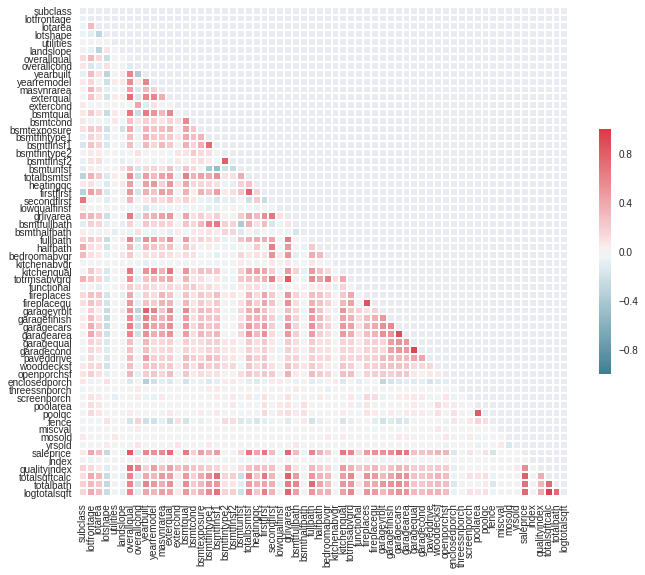

In [30]:
#Create a heatmap to check for correlated variables
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
        square=True, linewidths=1, xticklabels = True, yticklabels = True, cbar_kws={"shrink": .5})

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


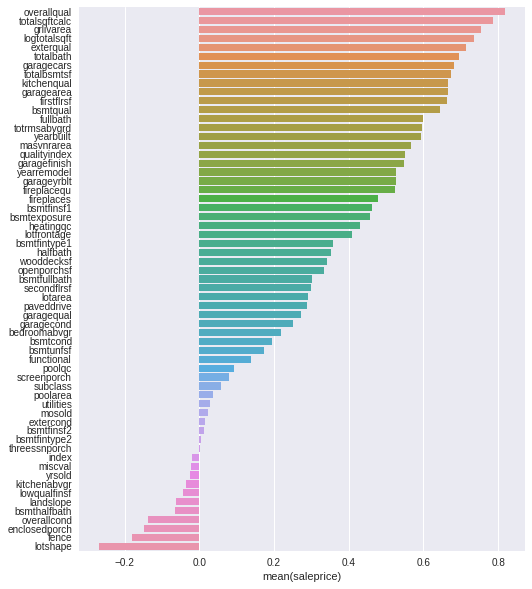

In [31]:
# Feature sorted by correlation to SalePrice, from positive to negative
corr = corr.sort_values('saleprice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.saleprice[1:], corr.index[1:], orient='h')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


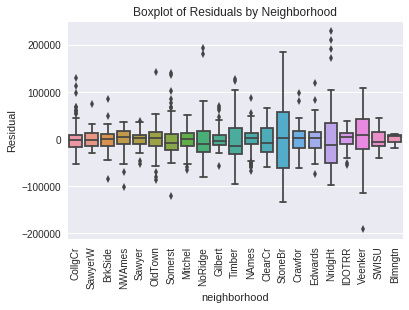

                    index      saleprice  totalsqftcalc    p_saleprice      residual      a_ppsf      p_ppsf
neighborhood                                                                                                
Blmngtn       1988.333333  177689.000000    1259.333333  177689.000000 -1.260390e-07  141.147876  141.102163
BrkSide       1468.246914  124530.246914    1447.259259  124530.246914 -1.205200e-07   88.653210   88.625648
ClearCr       1440.964286  213101.142857    2510.500000  213101.142857  2.690441e-08   85.557711   86.411102
CollgCr       1431.414773  203288.971591    2031.437500  203288.971591 -5.506974e-08  103.232639  104.466967
Crawfor       1620.591549  202112.281690    2185.690141  202112.281690  2.378152e-08   95.725418   97.416622
...                   ...            ...            ...            ...           ...         ...         ...
SawyerW       1468.760563  186940.563380    2068.338028  186940.563380 -3.497379e-08   94.613572   96.272366
Somerst       1553.

In [32]:
#model submission from Assignment01
model = smf.ols(formula='saleprice ~ overallqual + grlivarea + neighborhood + yearbuilt', data=train).fit()
#calculate residuals
#the next code is using my model in the shell code
train_predictions = model.fittedvalues
train_predictions.head()
tr = {'p_saleprice': train_predictions}
df1 = train[['index','saleprice','neighborhood','totalsqftcalc']]
df2=pd.DataFrame(data=tr)
n_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])

n_file['residual'] = (n_file.saleprice-n_file.p_saleprice)
n_file['a_ppsf'] = (n_file.saleprice/n_file.totalsqftcalc)
n_file['p_ppsf'] = (n_file.p_saleprice/n_file.totalsqftcalc)
n_file

ax = sns.boxplot(x="neighborhood", y="residual", data=n_file)
ax.set_title("Boxplot of Residuals by Neighborhood")
ax.set_ylabel("Residual")
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

g = n_file.groupby('neighborhood').mean() 
g

In [33]:
#Compute the actual mean price per square foot by neighborhood
ppsf_by_neighborhood = n_file['a_ppsf'].groupby([n_file['neighborhood']]).mean()
ppsf_by_neighborhood

neighborhood
Blmngtn    141.147876
BrkSide     88.653210
ClearCr     85.557711
CollgCr    103.232639
Crawfor     95.725418
              ...    
SawyerW     94.613572
Somerst    123.757451
StoneBr    124.694044
Timber     107.034638
Veenker     84.524098
Name: a_ppsf, Length: 21, dtype: float64

In [34]:
upper_quartile = ppsf_by_neighborhood.quantile(q=0.75)
upper_quartile

105.1287425583947

In [35]:
lower_quartile = ppsf_by_neighborhood.quantile(q=0.25)
lower_quartile

83.85768977408166

In [36]:
big = ppsf_by_neighborhood[ppsf_by_neighborhood >= upper_quartile]
big

neighborhood
Blmngtn    141.147876
Gilbert    105.128743
NridgHt    127.054716
Somerst    123.757451
StoneBr    124.694044
Timber     107.034638
Name: a_ppsf, dtype: float64

In [37]:
medium = ppsf_by_neighborhood[(ppsf_by_neighborhood > lower_quartile) & (ppsf_by_neighborhood < upper_quartile)]                                                                    
medium

neighborhood
BrkSide     88.653210
ClearCr     85.557711
CollgCr    103.232639
Crawfor     95.725418
Mitchel     85.801194
NoRidge     98.638210
OldTown     85.893530
SawyerW     94.613572
Veenker     84.524098
Name: a_ppsf, dtype: float64

In [38]:
small = ppsf_by_neighborhood[ppsf_by_neighborhood <= lower_quartile]
small

neighborhood
Edwards    83.658217
IDOTRR     79.658569
NAmes      82.413392
NWAmes     82.996141
SWISU      77.707044
Sawyer     83.857690
Name: a_ppsf, dtype: float64

In [0]:
#Create "small" = group1 indicator variable
train["group1"] = train['neighborhood'].isin(['Edwards','IDOTRR','NAmes','NWAmes','SWISU','Sawyer'])
train.group1 = train.group1.astype(int)
test["group1"] = test['neighborhood'].isin(['Edwards','IDOTRR','NAmes','NWAmes','SWISU','Sawyer'])
test.group1 = test.group1.astype(int)

In [0]:
#Create "medium" = group2 indicator variable
train["group2"] = train['neighborhood'].isin(['BrkSide','ClearCr','CollgCr','Crawfor','Mitchel','NoRidge','OldTown','SawyerW','Veenker'])
train.group2 = train.group2.astype(int)
test["group2"] = test['neighborhood'].isin(['BrkSide','ClearCr','CollgCr','Crawfor','Mitchel','NoRidge','OldTown','SawyerW','Veenker'])
test.group2 = test.group2.astype(int)

In [41]:
train.head()

   subclass zoning  lotfrontage  lotarea street alley  lotshape landcontour  utilities lotconfig  landslope  \
0        20     RL         70.0    11838   Pave    NA         4         Lvl          4    Inside          3   
1        60     RL         70.0     8304   Pave    NA         3         Lvl          4    Inside          3   
2        45     RM         58.0     6380   Pave    NA         4         Lvl          4    Inside          3   
3        60     RL         80.0    14803   Pave    NA         3         Lvl          4   CulDSac          3   
4        20     RL         91.0    11375   Pave    NA         4         Lvl          4    Inside          3   

  neighborhood condition1 condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  yearremodel   ...    \
0      CollgCr       Norm       Norm     1Fam     1Story            8            5       2001         2001   ...     
1      SawyerW       Norm       Norm     1Fam     2Story            6            5       1997    

In [0]:
#Set variable list
y = train['saleprice']

In [43]:
#  Benchmark model1: from HW02 Shell Code
#Code for linear regression with categorical variables c()
model1 = smf.ols(formula='y ~ qualityindex+totalsqftcalc+C(lotconfig)+C(housestyle)+yearbuilt+C(roofstyle)+C(heating)', data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     270.1
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:07   Log-Likelihood:                -20221.
No. Observations:                1696   AIC:                         4.049e+04
Df Residuals:                    1671   BIC:                         4.063e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.801e+06   7.97e+04    -22.599      0.000   -1.96e+06   -1.64e+06
C(lotconfig)[T.CulDSac]  3893.0533   4156.158      0.937      0.349   -4258.772     1.2e+04
C(lotconfig)[T.FR2]      -382.9957   6697.635     -0.057      0.954   -1.35e+04    1.28e+04
C(lotconfig)[T.FR3]     -2744.7871   1.32e+04     -0.208      0.835   -2.86e+04    2.31e+04
C(lotconfig)[T.Inside]   1295.7344   2343.936      0.553      0.580   -3301.625    5893.094
C(housestyle)[T.1.5Unf]  1.187e+04   1.03e+04      1.156      0.248   -8259.349     3.2e+04
C(housestyle)[T.1Story] -8668.1787   3195.979     -2.712      0.007   -1.49e+04   -2399.634
C(housestyle)[T.2.5Fin]  1.045e+04   1.68e+04      0.623      0.533   -2.24e+04    4.33e+04
C(housestyle)[T.2.5Unf]  9004.8120   1.06e+04      0.851      0.395   -1.17e+04    2.97e+04
C(housestyle)[T.2Story] -5853.3951   3470.506     -1.687      0.092   -1.27e+04     953.603
C(housestyle)[T.SFoyer]     -3e+04   6729.527     -4.457      0.000   -4.32e+04   -1.68e+04
C(housestyle)[T.SLvl]   -2.947e+04   5094.513     -5.786      0.000   -3.95e+04   -1.95e+04
C(roofstyle)[T.Gable]   -1.428e+04   1.25e+04     -1.145      0.252   -3.88e+04    1.02e+04
C(roofstyle)[T.Gambr]   -5353.8867    1.5e+04     -0.357      0.721   -3.48e+04    2.41e+04
C(roofstyle)[T.Hip]      2023.2516   1.26e+04      0.161      0.872   -2.26e+04    2.67e+04
C(roofstyle)[T.Mansa]   -7248.4346   1.86e+04     -0.389      0.697   -4.37e+04    2.93e+04
C(roofstyle)[T.Shed]    -2.668e+04   2.46e+04     -1.084      0.278    -7.5e+04    2.16e+04
C(heating)[T.GasA]      -8904.5959   3.69e+04     -0.241      0.809   -8.13e+04    6.35e+04
C(heating)[T.GasW]      -1807.1944   3.78e+04     -0.048      0.962    -7.6e+04    7.24e+04
C(heating)[T.Grav]       9073.6891   4.04e+04      0.225      0.822   -7.02e+04    8.83e+04
C(heating)[T.OthW]      -2.973e+04   5.23e+04     -0.568      0.570   -1.32e+05    7.29e+04
C(heating)[T.Wall]       3467.9849   5.22e+04      0.066      0.947   -9.88e+04    1.06e+05
qualityindex             2416.4728    106.921     22.601      0.000    2206.760    2626.185
totalsqftcalc              57.5507      1.512     38.071      0.000      54.586      60.516
yearbuilt                 920.8668     36.789     25.031      0.000     848.710     993.024
==============================================================================
Omnibus:                      546.339   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3233.818
Skew:                           1.378   Prob(JB):                         0.00
Kurtosis:                       9.178   Cond. No.                     3.21e+05
==============================================================================

Warnings:
[1] Standard Errors as

In [44]:
#  Benchmark model2: added neighborhood to HW02 Shell Code
model2 = smf.ols(formula='y ~ qualityindex+totalsqftcalc+C(neighborhood)+yearbuilt', data=train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     467.7
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:08   Log-Likelihood:                -19864.
No. Observations:                1696   AIC:                         3.978e+04
Df Residuals:                    1672   BIC:                         3.991e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -1.11e+06   1.08e+05    -10.280      0.000   -1.32e+06   -8.98e+05
C(neighborhood)[T.BrkSide] -1.511e+04    1.8e+04     -0.842      0.400   -5.03e+04    2.01e+04
C(neighborhood)[T.ClearCr] -1632.7555   1.83e+04     -0.089      0.929   -3.75e+04    3.42e+04
C(neighborhood)[T.CollgCr] -8077.0972   1.74e+04     -0.465      0.642   -4.21e+04     2.6e+04
C(neighborhood)[T.Crawfor]  4916.1283   1.79e+04      0.274      0.784   -3.03e+04    4.01e+04
C(neighborhood)[T.Edwards] -2.091e+04   1.77e+04     -1.184      0.236   -5.55e+04    1.37e+04
C(neighborhood)[T.Gilbert] -1.016e+04   1.74e+04     -0.583      0.560   -4.44e+04     2.4e+04
C(neighborhood)[T.IDOTRR]  -1.613e+04   1.82e+04     -0.887      0.375   -5.18e+04    1.95e+04
C(neighborhood)[T.Mitchel] -2.591e+04   1.77e+04     -1.465      0.143   -6.06e+04    8769.610
C(neighborhood)[T.NAmes]   -2.809e+04   1.75e+04     -1.606      0.109   -6.24e+04    6222.930
C(neighborhood)[T.NWAmes]  -3.162e+04   1.76e+04     -1.793      0.073   -6.62e+04    2966.844
C(neighborhood)[T.NoRidge]  3.345e+04   1.79e+04      1.870      0.062   -1629.388    6.85e+04
C(neighborhood)[T.NridgHt]  8.081e+04   1.76e+04      4.587      0.000    4.63e+04    1.15e+05
C(neighborhood)[T.OldTown] -1.859e+04   1.79e+04     -1.037      0.300   -5.37e+04    1.66e+04
C(neighborhood)[T.SWISU]   -1.847e+04   1.88e+04     -0.983      0.326   -5.53e+04    1.84e+04
C(neighborhood)[T.Sawyer]  -2.913e+04   1.76e+04     -1.651      0.099   -6.37e+04    5484.612
C(neighborhood)[T.SawyerW]  -2.22e+04   1.76e+04     -1.262      0.207   -5.67e+04    1.23e+04
C(neighborhood)[T.Somerst]  2.522e+04   1.75e+04      1.438      0.151   -9189.535    5.96e+04
C(neighborhood)[T.StoneBr]  1.015e+05   1.89e+04      5.382      0.000    6.45e+04    1.39e+05
C(neighborhood)[T.Timber]   1.191e+04   1.77e+04      0.673      0.501   -2.28e+04    4.66e+04
C(neighborhood)[T.Veenker] -1.367e+04   1.92e+04     -0.710      0.478   -5.14e+04    2.41e+04
qualityindex                1933.1840     89.132     21.689      0.000    1758.362    2108.006
totalsqftcalc                 51.0808      1.277     39.998      0.000      48.576      53.586
yearbuilt                    575.7189     53.113     10.839      0.000     471.543     679.894
==============================================================================
Omnibus:                      550.709   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4115.098
Skew:                           1.315   Prob(JB):                         0.00
Kurtosis:                      10.164   Cond. No.                     4.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that t

In [45]:
#  BEST MODEL:  SUBMISSTION FOR ASSIGNMENT02 *** DO NOT DELETE ***
model3 = smf.ols(formula='y ~ overallqual + grlivarea + C(neighborhood) + yearbuilt + totalbath', data=train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     405.6
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:08   Log-Likelihood:                -19937.
No. Observations:                1696   AIC:                         3.992e+04
Df Residuals:                    1671   BIC:                         4.006e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -8.07e+05   1.16e+05     -6.929      0.000   -1.04e+06   -5.79e+05
C(neighborhood)[T.BrkSide]  1.747e+04   1.87e+04      0.932      0.352   -1.93e+04    5.42e+04
C(neighborhood)[T.ClearCr]  3.329e+04   1.91e+04      1.746      0.081   -4099.832    7.07e+04
C(neighborhood)[T.CollgCr]  1.451e+04   1.81e+04      0.801      0.423    -2.1e+04       5e+04
C(neighborhood)[T.Crawfor]  3.969e+04   1.87e+04      2.122      0.034    3010.354    7.64e+04
C(neighborhood)[T.Edwards]  1.447e+04   1.84e+04      0.785      0.433   -2.17e+04    5.06e+04
C(neighborhood)[T.Gilbert] -3799.3557   1.82e+04     -0.208      0.835   -3.95e+04    3.19e+04
C(neighborhood)[T.IDOTRR]   1.158e+04    1.9e+04      0.610      0.542   -2.57e+04    4.88e+04
C(neighborhood)[T.Mitchel]   2.05e+04   1.85e+04      1.111      0.267   -1.57e+04    5.67e+04
C(neighborhood)[T.NAmes]    1.863e+04   1.83e+04      1.020      0.308   -1.72e+04    5.44e+04
C(neighborhood)[T.NWAmes]   3338.0871   1.84e+04      0.181      0.856   -3.27e+04    3.94e+04
C(neighborhood)[T.NoRidge]  5.246e+04   1.86e+04      2.816      0.005    1.59e+04     8.9e+04
C(neighborhood)[T.NridgHt]  9.508e+04   1.84e+04      5.180      0.000    5.91e+04    1.31e+05
C(neighborhood)[T.OldTown]  1.199e+04   1.87e+04      0.641      0.522   -2.47e+04    4.87e+04
C(neighborhood)[T.SWISU]    2615.6166   1.96e+04      0.133      0.894   -3.58e+04    4.11e+04
C(neighborhood)[T.Sawyer]   2.099e+04   1.84e+04      1.139      0.255   -1.52e+04    5.71e+04
C(neighborhood)[T.SawyerW] -1558.2356   1.84e+04     -0.085      0.932   -3.76e+04    3.44e+04
C(neighborhood)[T.Somerst]  3.528e+04   1.83e+04      1.928      0.054    -608.900    7.12e+04
C(neighborhood)[T.StoneBr]  1.188e+05   1.96e+04      6.046      0.000    8.02e+04    1.57e+05
C(neighborhood)[T.Timber]   3.652e+04   1.84e+04      1.980      0.048     334.634    7.27e+04
C(neighborhood)[T.Veenker]  3.107e+04      2e+04      1.552      0.121   -8185.934    7.03e+04
overallqual                 1.796e+04    923.677     19.444      0.000    1.61e+04    1.98e+04
grlivarea                     50.8053      2.424     20.959      0.000      46.051      55.560
yearbuilt                    381.4871     57.952      6.583      0.000     267.822     495.152
totalbath                   1.466e+04   1477.867      9.919      0.000    1.18e+04    1.76e+04
==============================================================================
Omnibus:                      523.683   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5105.998
Skew:                           1.156   Prob(JB):                         0.00
Kurtosis:                      11.180   Cond. No.                     3.96e+05
============================

In [46]:
#Code for linear regression with categorical variables c()
model4 = smf.ols(formula='y ~ overallqual + totalsqftcalc + C(neighborhood) + yearbuilt + totalbath + C(housestyle) + lotarea', data=train).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     373.4
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:08   Log-Likelihood:                -19783.
No. Observations:                1696   AIC:                         3.963e+04
Df Residuals:                    1663   BIC:                         3.981e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -7.478e+05    1.1e+05     -6.799      0.000   -9.64e+05   -5.32e+05
C(neighborhood)[T.BrkSide]  2606.1352   1.72e+04      0.151      0.880   -3.12e+04    3.64e+04
C(neighborhood)[T.ClearCr]   452.3393   1.76e+04      0.026      0.979    -3.4e+04    3.49e+04
C(neighborhood)[T.CollgCr] -3916.2737   1.66e+04     -0.236      0.814   -3.65e+04    2.87e+04
C(neighborhood)[T.Crawfor]  2.036e+04   1.72e+04      1.186      0.236   -1.33e+04     5.4e+04
C(neighborhood)[T.Edwards] -4331.0691   1.69e+04     -0.256      0.798   -3.75e+04    2.89e+04
C(neighborhood)[T.Gilbert] -4958.9089   1.67e+04     -0.296      0.767   -3.78e+04    2.79e+04
C(neighborhood)[T.IDOTRR]  -2355.0872   1.74e+04     -0.135      0.892   -3.65e+04    3.18e+04
C(neighborhood)[T.Mitchel] -9936.7976    1.7e+04     -0.585      0.558   -4.32e+04    2.34e+04
C(neighborhood)[T.NAmes]   -1.034e+04   1.68e+04     -0.617      0.538   -4.32e+04    2.25e+04
C(neighborhood)[T.NWAmes]  -1.745e+04   1.69e+04     -1.033      0.302   -5.06e+04    1.57e+04
C(neighborhood)[T.NoRidge]  3.324e+04   1.71e+04      1.940      0.053    -362.086    6.68e+04
C(neighborhood)[T.NridgHt]  6.932e+04   1.69e+04      4.112      0.000    3.63e+04    1.02e+05
C(neighborhood)[T.OldTown]  -239.3917   1.72e+04     -0.014      0.989   -3.39e+04    3.34e+04
C(neighborhood)[T.SWISU]   -9230.4028    1.8e+04     -0.512      0.608   -4.46e+04    2.61e+04
C(neighborhood)[T.Sawyer]  -9345.5794   1.69e+04     -0.552      0.581   -4.26e+04    2.39e+04
C(neighborhood)[T.SawyerW] -1.616e+04   1.68e+04     -0.959      0.338   -4.92e+04    1.69e+04
C(neighborhood)[T.Somerst]    2.1e+04   1.68e+04      1.252      0.211   -1.19e+04    5.39e+04
C(neighborhood)[T.StoneBr]  8.884e+04    1.8e+04      4.922      0.000    5.34e+04    1.24e+05
C(neighborhood)[T.Timber]   8543.9443    1.7e+04      0.504      0.614   -2.47e+04    4.18e+04
C(neighborhood)[T.Veenker] -8391.5183   1.84e+04     -0.455      0.649   -4.46e+04    2.78e+04
C(housestyle)[T.1.5Unf]     6116.9397   8004.410      0.764      0.445   -9582.842    2.18e+04
C(housestyle)[T.1Story]     3522.5708   2550.521      1.381      0.167   -1480.000    8525.141
C(housestyle)[T.2.5Fin]     2.291e+04   1.32e+04      1.741      0.082   -2902.513    4.87e+04
C(housestyle)[T.2.5Unf]    -1.056e+04   8298.776     -1.272      0.204   -2.68e+04    5721.556
C(housestyle)[T.2Story]     1308.6971   2747.598      0.476      0.634   -4080.418    6697.813
C(housestyle)[T.SFoyer]     1110.3726   5386.459      0.206      0.837   -9454.582    1.17e+04
C(housestyle)[T.SLvl]      -5425.5476   4051.883     -1.339      0.181   -1.34e+04    2521.781
overallqual                 2.018e+04    823.945     24.495      0.000    1.86e+04    2.18e+04
totalsqftcalc                 42.9690      

In [47]:
#linear regression with indicator variables
indicatormodel = smf.ols(formula='y ~ qualityindex+totalsqftcalc+group1+group2+yearbuilt', data=train).fit()
indicatormodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1482.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:08   Log-Likelihood:                -20138.
No. Observations:                1696   AIC:                         4.029e+04
Df Residuals:                    1690   BIC:                         4.032e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.084e+06   6.79e+04    -15.950      0.000   -1.22e+06    -9.5e+05
qualityindex   2144.8700    100.633     21.314      0.000    1947.492    2342.248
totalsqftcalc    60.4495      1.335     45.272      0.000      57.831      63.068
group1        -4.791e+04   2809.977    -17.049      0.000   -5.34e+04   -4.24e+04
group2        -3.451e+04   2601.477    -13.267      0.000   -3.96e+04   -2.94e+04
yearbuilt       561.7653     34.258     16.398      0.000     494.572     628.958
==============================================================================
Omnibus:                      582.561   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4330.552
Skew:                           1.407   Prob(JB):                         0.00
Kurtosis:                      10.305   Cond. No.                     2.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
# set predictions from best model:
predictions = model3.fittedvalues

Text(0, 0.5, 'Sale Price')

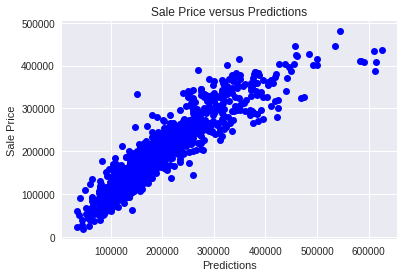

In [49]:
# Scatterplot of predictions from best model:
plt.plot(train['saleprice'], predictions, 'bo')
plt.title('Sale Price versus Predictions') 
plt.xlabel("Predictions") 
plt.ylabel("Sale Price")

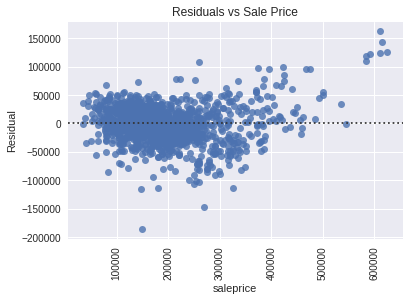

In [50]:
#calculate residuals
#the next code is using my model in the shell code
train_predictions3 = model3.fittedvalues
train_predictions3.head()
tr = {'p_saleprice': train_predictions3}
df1 = train[['index','saleprice']]
df2=pd.DataFrame(data=tr)
o_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])

o_file['residual'] = (n_file.saleprice-n_file.p_saleprice)
o_file

# scatterplot of y versus residuals, for eyeball check of (a) hetereoscedasticity and (b) serial autocorrelation.
ax = sns.residplot(x="saleprice", y="residual", data=o_file)
ax.set_title("Residuals vs Sale Price")
ax.set_ylabel("Residual")
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show()

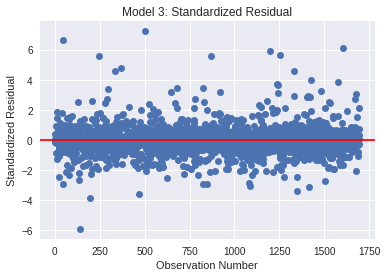

In [51]:
stdres = pd.DataFrame(model3.resid_pearson)
fig2 = plt.plot(stdres, 'o', ls = 'None')
l = plt.axhline(y=0, color ='r')
plt.title("Model 3: Standardized Residual") 
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')
print(fig2)

Text(0.5, 1.0, "Model 3: Cook's Distance Values")

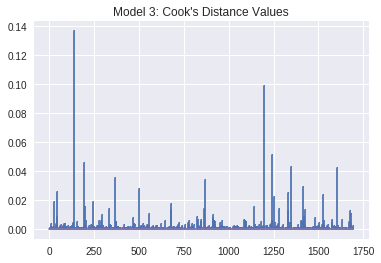

In [52]:
# Cook's distance value of more that 1 indicates an influential value, but you may want to look at values above 0.5..
influence = model3.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Model 3: Cook's Distance Values") 

In [53]:
print('')
print('----- Section 2:  Model Comparison of Y versus log(Y) -----')
print('')


----- Section 2:  Model Comparison of Y versus log(Y) -----



In [54]:
#linear regression model: discrete variables without (NO) log transformation
nolog = smf.ols(formula='y ~ totalsqftcalc+lotfrontage+garagearea+masvnrarea+yearbuilt', data=train).fit()
nolog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1107.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:13   Log-Likelihood:                -20333.
No. Observations:                1696   AIC:                         4.068e+04
Df Residuals:                    1690   BIC:                         4.071e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.175e+06   7.04e+04    -16.696      0.000   -1.31e+06   -1.04e+06
totalsqftcalc    55.9764      1.662     33.673      0.000      52.716      59.237
lotfrontage      12.7308     59.651      0.213      0.831    -104.267     129.729
garagearea       77.8243      5.832     13.344      0.000      66.385      89.263
masvnrarea       69.9639      6.377     10.971      0.000      57.456      82.472
yearbuilt       610.4749     36.544     16.705      0.000     538.798     682.152
==============================================================================
Omnibus:                      400.302   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2030.982
Skew:                           1.016   Prob(JB):                         0.00
Kurtosis:                       7.961   Cond. No.                     2.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
#some code for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Break into left and right hand side; y and X
y, X = dmatrices( "y ~ totalsqftcalc+lotfrontage+garagearea+masvnrarea+yearbuilt", data=train, return_type="dataframe")
# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Fit X to y
result = sm.OLS(y, X).fit()
vif

[5515.375752718401,
 1.6482036834253984,
 1.2881166425813737,
 1.7646738220931086,
 1.4117752739377947,
 1.4330730135444267]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


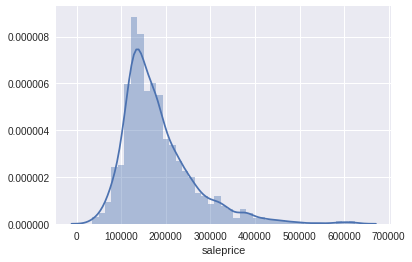

In [56]:
sns.distplot(train['saleprice'])

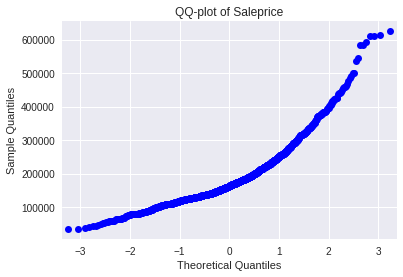

In [57]:
sm.qqplot(train['saleprice'])
plt.title('QQ-plot of Saleprice') 
plt.show()

In [0]:
nologpredictions = nolog.fittedvalues

Text(0, 0.5, 'Sale Price')

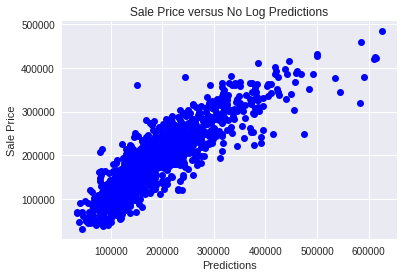

In [59]:
plt.plot(train['saleprice'], nologpredictions, 'bo')
plt.title('Sale Price versus No Log Predictions') 
plt.xlabel("Predictions") 
plt.ylabel("Sale Price")

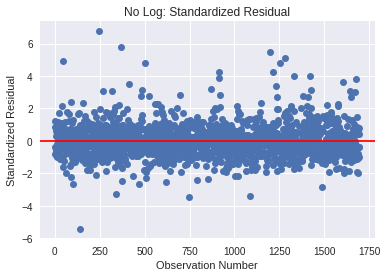

In [60]:
stdres = pd.DataFrame(nolog.resid_pearson)
fig3 = plt.plot(stdres, 'o', ls = 'None')
l = plt.axhline(y=0, color ='r')
plt.title("No Log: Standardized Residual") 
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')
print(fig3)

Text(0.5, 1.0, "No Log: Cook's Distance Values")

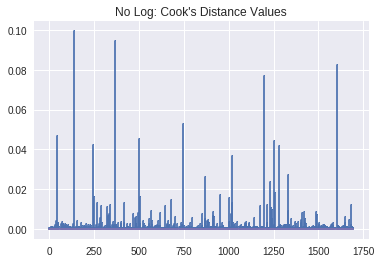

In [61]:
# Cook's distance value of more that 1 indicates an influential value, but you may want to look at values above 0.5..
influence = nolog.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("No Log: Cook's Distance Values") 

In [0]:
#log transformation to saleprice
train['log_y'] = train['saleprice'].apply(np.log)

In [63]:
#linear regression model: discrete variables WITH log transformation
logmodel = smf.ols(formula='log_y ~ totalsqftcalc+lotfrontage+garagearea+masvnrarea+yearbuilt', data=train).fit()
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     1197.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:19   Log-Likelihood:                 404.82
No. Observations:                1696   AIC:                            -797.6
Df Residuals:                    1690   BIC:                            -765.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.8502      0.344      8.278      0.000       2.175       3.526
totalsqftcalc     0.0003   8.13e-06     34.693      0.000       0.000       0.000
lotfrontage       0.0002      0.000      0.593      0.553      -0.000       0.001
garagearea        0.0004   2.85e-05     13.764      0.000       0.000       0.000
masvnrarea        0.0001   3.12e-05      4.078      0.000     6.6e-05       0.000
yearbuilt         0.0043      0.000     23.889      0.000       0.004       0.005
==============================================================================
Omnibus:                      126.540   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.734
Skew:                          -0.216   Prob(JB):                    1.04e-117
Kurtosis:                       5.727   Cond. No.                     2.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
#some code for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Break into left and right hand side; y and X
y, X = dmatrices( "log_y ~ totalsqftcalc+lotfrontage+garagearea+masvnrarea+yearbuilt", data=train, return_type="dataframe")
# For each Xi, calculate VIF
vif2 = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Fit X to y
result = sm.OLS(y, X).fit()
vif2

[5515.375752718401,
 1.6482036834253984,
 1.2881166425813737,
 1.7646738220931086,
 1.4117752739377947,
 1.4330730135444267]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


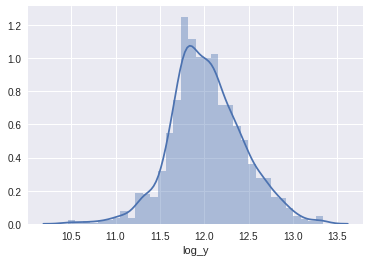

In [65]:
sns.distplot(train['log_y'])

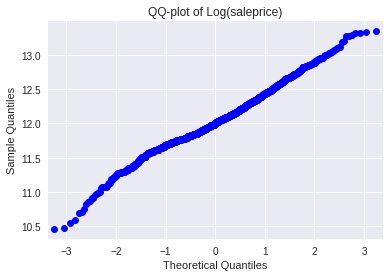

In [66]:
sm.qqplot(train['log_y'])
plt.title('QQ-plot of Log(saleprice)') 
plt.show()

In [0]:
logpredictions = logmodel.fittedvalues

Text(0, 0.5, 'Sale Price')

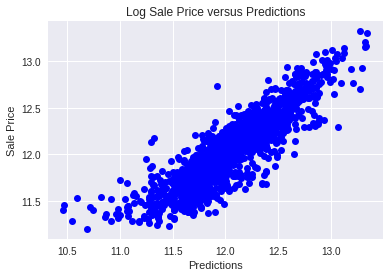

In [68]:
plt.plot(train['log_y'], logpredictions, 'bo')
plt.title('Log Sale Price versus Predictions') 
plt.xlabel("Predictions") 
plt.ylabel("Sale Price")

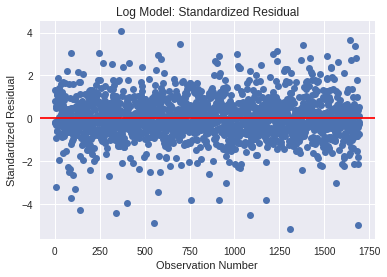

In [69]:
stdres = pd.DataFrame(logmodel.resid_pearson)
fig4 = plt.plot(stdres, 'o', ls = 'None')
l = plt.axhline(y=0, color ='r')
plt.title("Log Model: Standardized Residual") 
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')
print(fig4)

Text(0.5, 1.0, "Log Model: Cook's Distance Values")

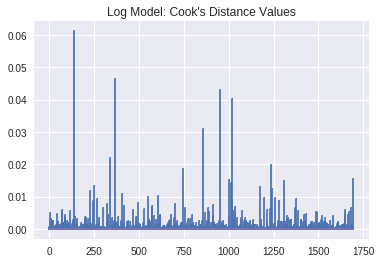

In [70]:
# Cook's distance value of more that 1 indicates an influential value, but you may want to look at values above 0.5..
influence = logmodel.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Log Model: Cook's Distance Values")

In [71]:
# Let's try the log transformation of saleprice vs the log transformation of totalsqftcalc
logvarmodel = smf.ols(formula='log_y ~ logtotalsqft + C(overallqual) + C(neighborhood) + yearbuilt', data=train).fit()
logvarmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     388.6
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:00:25   Log-Likelihood:                 910.16
No. Observations:                1696   AIC:                            -1756.
Df Residuals:                    1664   BIC:                            -1582.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.6259      0.547      6.624      0.000       2.552       4.700
C(overallqual)[T.2]           -0.0041      0.153     -0.026      0.979      -0.305       0.297
C(overallqual)[T.3]            0.2050      0.147      1.394      0.164      -0.084       0.494
C(overallqual)[T.4]            0.3663      0.145      2.531      0.011       0.082       0.650
C(overallqual)[T.5]            0.4761      0.144      3.302      0.001       0.193       0.759
C(overallqual)[T.6]            0.5664      0.144      3.923      0.000       0.283       0.850
C(overallqual)[T.7]            0.6789      0.145      4.694      0.000       0.395       0.963
C(overallqual)[T.8]            0.8084      0.145      5.575      0.000       0.524       1.093
C(overallqual)[T.9]            0.9629      0.147      6.571      0.000       0.676       1.250
C(overallqual)[T.10]           1.1147      0.150      7.452      0.000       0.821       1.408
C(neighborhood)[T.BrkSide]    -0.0574      0.087     -0.663      0.507      -0.227       0.112
C(neighborhood)[T.ClearCr]     0.0657      0.088      0.746      0.456      -0.107       0.238
C(neighborhood)[T.CollgCr]    -0.0376      0.084     -0.450      0.653      -0.202       0.126
C(neighborhood)[T.Crawfor]     0.1290      0.086      1.494      0.135      -0.040       0.298
C(neighborhood)[T.Edwards]    -0.0960      0.085     -1.127      0.260      -0.263       0.071
C(neighborhood)[T.Gilbert]    -0.0190      0.084     -0.227      0.821      -0.184       0.146
C(neighborhood)[T.IDOTRR]     -0.1688      0.088     -1.926      0.054      -0.341       0.003
C(neighborhood)[T.Mitchel]    -0.0658      0.085     -0.770      0.441      -0.233       0.102
C(neighborhood)[T.NAmes]      -0.0730      0.084     -0.864      0.387      -0.239       0.093
C(neighborhood)[T.NWAmes]     -0.0663      0.085     -0.780      0.436      -0.233       0.100
C(neighborhood)[T.NoRidge]     0.0860      0.086      0.997      0.319      -0.083       0.255
C(neighborhood)[T.NridgHt]     0.1259      0.086      1.469      0.142      -0.042       0.294
C(neighborhood)[T.OldTown]    -0.0729      0.086     -0.845      0.398      -0.242       0.096
C(neighborhood)[T.SWISU]      -0.0764      0.091     -0.844      0.399      -0.254       0.101
C(neighborhood)[T.Sawyer]     -0.0838      0.085     -0.983      0.326      -0.251       0.083
C(neighborhood)[T.SawyerW]    -0.0784      0.085     -0.926      0.355      -0.244       0.088
C(neighborhood)[T.Somerst]     0.0553      0.085      0.654      0.513      -0.111       0.221
C(neighborhood)[T.StoneBr]     0.1566      0.092      1.710      0.087      -0.023       0.336
C(neighborhood)[T.Timber]      0.0233      0.085      0.273      0.785      -0.144       0.191
C(neighborhood)[T.Veenker]    -0.0240      

In [0]:
train_predictions = logvarmodel.fittedvalues

Text(0, 0.5, 'Log Sale Price')

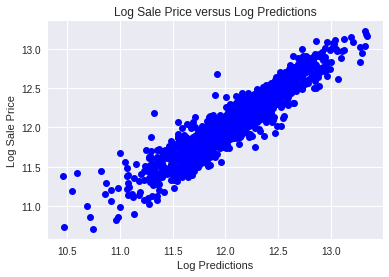

In [73]:
plt.plot(train['log_y'], train_predictions, 'bo')
plt.title('Log Sale Price versus Log Predictions') 
plt.xlabel("Log Predictions") 
plt.ylabel("Log Sale Price")

In [74]:
train_predictions.head() 
preds = np.exp(train_predictions) 
preds.head() 

0    222048.975168
1    167677.516347
2    103314.556688
3    178860.652530
4    157197.623168
dtype: float64

In [75]:
print('')
print('----- Optional:  Automated Variable Selection -----')
print('')


----- Optional:  Automated Variable Selection -----



In [76]:
Y = train[['saleprice']].copy()
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_top_3 = SelectKBest(score_func=chi2, k = "all")
fit = select_top_3.fit(X1,Y)
features = fit.transform(X1)
features[0:5]

array([[   40.,  1788.,  2001., 11838.,    70.],
       [   30.,  1837.,  1997.,  8304.,    70.],
       [   30.,  1048.,  1922.,  6380.,    58.],
       [   30.,  2409.,  1971., 14803.,    80.],
       [   30.,  2035.,  1954., 11375.,    91.]])

In [77]:
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
names = X1.columns.values[select_top_3.get_support()]
scores = select_top_3.scores_[select_top_3.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'X_square'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['X_square', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

      Feat_names      X_square
3        lotarea  6.478332e+06
1  totalsqftcalc  3.761585e+05
4    lotfrontage  4.134993e+03
0   qualityindex  2.701945e+03
2      yearbuilt  5.798114e+02


In [78]:
Y = train[['saleprice']].copy()
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
select_top_3 = SelectKBest(score_func=f_regression, k = "all")
fit = select_top_3.fit(X1,Y)
features = fit.transform(X1)
features[0:5]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[   40.,  1788.,  2001., 11838.,    70.],
       [   30.,  1837.,  1997.,  8304.,    70.],
       [   30.,  1048.,  1922.,  6380.,    58.],
       [   30.,  2409.,  1971., 14803.,    80.],
       [   30.,  2035.,  1954., 11375.,    91.]])

In [79]:
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
names = X1.columns.values[select_top_3.get_support()]
scores = select_top_3.scores_[select_top_3.get_support()]
pvalues = select_top_3.pvalues_[select_top_3.get_support()]
names_scores = list(zip(names, scores, pvalues))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_stat','p_value'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_stat', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

      Feat_names       F_stat        p_value
1  totalsqftcalc  2741.161654   0.000000e+00
2      yearbuilt   920.810860  6.781441e-162
0   qualityindex   733.179368  1.799471e-134
4    lotfrontage   339.900076   2.565160e-69
3        lotarea   157.073981   1.592488e-34


In [80]:
print('')
print('----- Section 3:  Select Models -----')
print('')


----- Section 3:  Select Models -----



In [81]:
#Convert the array predictions to a data frame then merge with the index for the test data to create your file
test_predictions = model3.predict(test)
print(test_predictions)
d = {'p_saleprice': test_predictions}
df1 = test[['index']]
df2=pd.DataFrame(data=d)
your_file = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])

0       52179.769608
1      260608.814674
2      199342.734021
3      205782.899794
4      195082.122549
           ...      
721    210795.802194
722    391391.264036
723    154357.573360
724    188385.786744
725    136766.317870
Length: 726, dtype: float64


In [82]:
print('')
print('----- Section 4:  Model Formula -----')
print('')


----- Section 4:  Model Formula -----



In [83]:
print (model3.params)

Intercept                    -806973.174372
C(neighborhood)[T.BrkSide]     17473.195399
C(neighborhood)[T.ClearCr]     33287.479870
C(neighborhood)[T.CollgCr]     14514.153486
C(neighborhood)[T.Crawfor]     39685.336277
                                  ...      
C(neighborhood)[T.Veenker]     31067.879249
overallqual                    17959.781642
grlivarea                         50.805336
yearbuilt                        381.487096
totalbath                      14659.124047
Length: 25, dtype: float64


In [84]:
print('')
print('----- Section 5:  Scored Data File -----')
print('')


----- Section 5:  Scored Data File -----



In [0]:
#Submit your file as csv using the following code to save on your computer
#You will have to delete the first column in the csv file to submit to kaggle 
# your_file.to_csv('hw02_predictions.csv')  

#### Conclusion

Several models were developed and tested to predict the sale price of a home using Ames housing train data. The best multiple regression model was derived using overall quality, above ground living area (square feet), neighborhood, total bathrooms, and year built as predictor variables of sale price. Other models were tested that resulted in higher R-squared values, but the model selected is more parsimonious with a lower AIC and BIC, and the lowest RMSE. These models were tested using Forward, Stepwise, and automated feature selection techniques. Although there were no problems detected with the various regression models, the variables should be explored further to see if the predictions would result in a more accurate sale price. For example, the log transformation of the dependent variable sale price showed promise in improving the model. Out of range predictions were fixed by eliminating outliers and applying drop conditions for a more accurate model. Additionally, through residual analysis we identified potential skewing that may require further data transformations. These issues should be explored with further EDA, before more complex model building such as ridge regression or LASSO is tested.